In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv('/kaggle/input/amazon-reviews/Reviews.csv')

# Display dataset structure
print(df.head())
print(df.info())  # Check for missing values & data types

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

We will classify reviews into:

Positive (1) → Scores ≥ 4
Negative (0) → Scores ≤ 2
Remove neutral (score = 3)

In [2]:
# Drop missing values
df = df.dropna(subset=['Score', 'Text'])

# Convert ratings into binary labels
df = df[df['Score'] != 3]  # Remove neutral reviews
df['label'] = df['Score'].apply(lambda x: 1 if x >= 4 else 0)  # 4-5 → Positive (1), 1-2 → Negative (0)

# Check class distribution
print(df['label'].value_counts())


label
1    443777
0     82037
Name: count, dtype: int64


Preprocess Text Data

In [3]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

# Apply text cleaning
df['cleaned_text'] = df['Text'].astype(str).apply(clean_text)

# Convert text into numerical vectors using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)  
X = vectorizer.fit_transform(df['cleaned_text'])

# Target variable
y = df['label']

# Split into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")


Training set: (368069, 5000), Testing set: (157745, 5000)


Train Models
1️⃣ Logistic Regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(max_iter=200)

logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)

print("🔹 Logistic Regression Results 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))


🔹 Logistic Regression Results 🔹
Accuracy: 0.9296079115027418
              precision    recall  f1-score   support

           0       0.84      0.68      0.75     24624
           1       0.94      0.98      0.96    133121

    accuracy                           0.93    157745
   macro avg       0.89      0.83      0.85    157745
weighted avg       0.93      0.93      0.93    157745



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2️⃣ Support Vector Machine (SVM)

Confusion Matrix

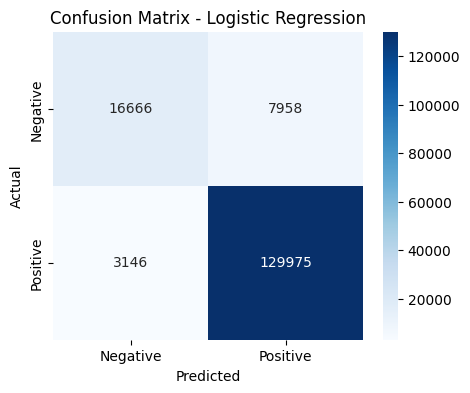

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot for each model
plot_confusion_matrix(y_test, y_pred_logreg, "Logistic Regression")
# plot_confusion_matrix(y_test, y_pred_svm, "SVM")
# plot_confusion_matrix(y_test, y_pred_nb, "Naïve Bayes")


Precision-Recall Curves

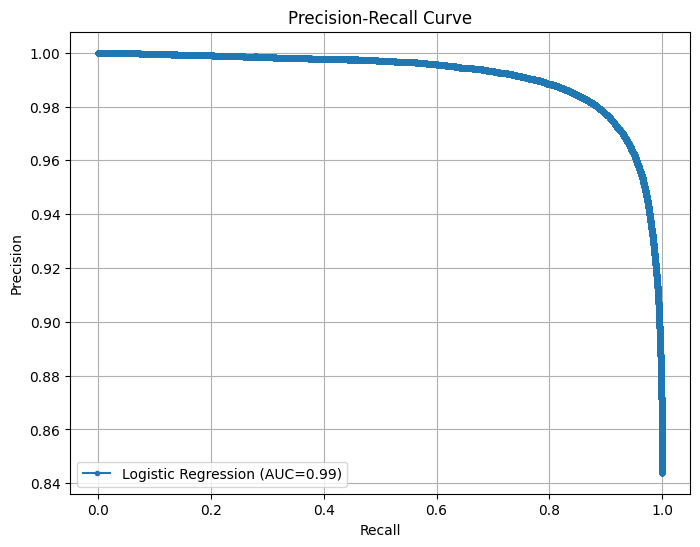

In [7]:
from sklearn.metrics import precision_recall_curve, auc

# Function to plot precision-recall curve
def plot_precision_recall(y_test, y_pred_proba, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auc_score = auc(recall, precision)
    
    plt.plot(recall, precision, marker='.', label=f'{model_name} (AUC={auc_score:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    
# Get probability predictions for models
y_pred_proba_logreg = logreg.predict_proba(X_test)[:,1]
# Plot all curves
plt.figure(figsize=(8,6))
plot_precision_recall(y_test, y_pred_proba_logreg, "Logistic Regression")
plt.show()


# Test and Understand Model Predictions

**Load & Preprocess Data**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load dataset
df = pd.read_csv("/kaggle/input/amazon-reviews/Reviews.csv")

# Drop missing values
df = df.dropna(subset=['Score', 'Text'])

# Select relevant columns
X = df['Text']  # Features (Review Text)
y = df['Score']  # Target (Ratings)

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  # Use top 5000 words
X_tfidf = vectorizer.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


**Train Regression Model**

In [9]:
# Train Linear Regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict on test set
y_pred = regressor.predict(X_test)

# Convert predictions to whole numbers (ratings should be 1 to 5)
y_pred_rounded = np.round(y_pred)


**Model Evaluation**

In [10]:
# Calculate Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.8020029946314142
Mean Absolute Error: 0.6725045610406167
R² Score: 0.5289972311875275


**Scatter Plot (Actual vs Predicted Ratings)**

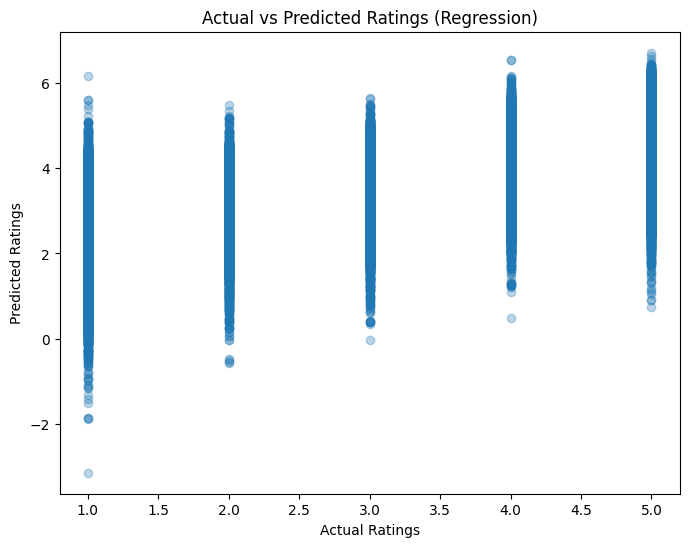

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Ratings (Regression)")
plt.show()


**Residual Plot**

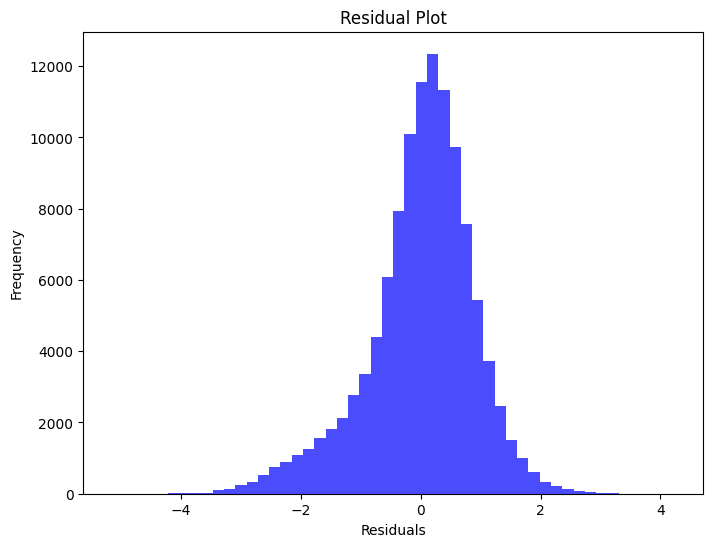

In [12]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, color="blue", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Residual Plot")
plt.show()


**Print Some Predictions vs. Actual Ratings**

In [14]:
# Convert predictions to whole numbers (ratings should be 1 to 5)
y_pred_rounded = np.round(y_pred)

# Create a DataFrame to compare actual vs predicted ratings
results_df = pd.DataFrame({'Actual Rating': y_test.values, 'Predicted Rating': y_pred_rounded})
print(results_df.sample(10))  # Print 10 random test samples


        Actual Rating  Predicted Rating
60264               5               5.0
82545               2               2.0
15626               3               5.0
93610               5               4.0
67904               5               5.0
105164              5               4.0
29370               5               5.0
60261               5               5.0
35673               5               4.0
24617               5               4.0


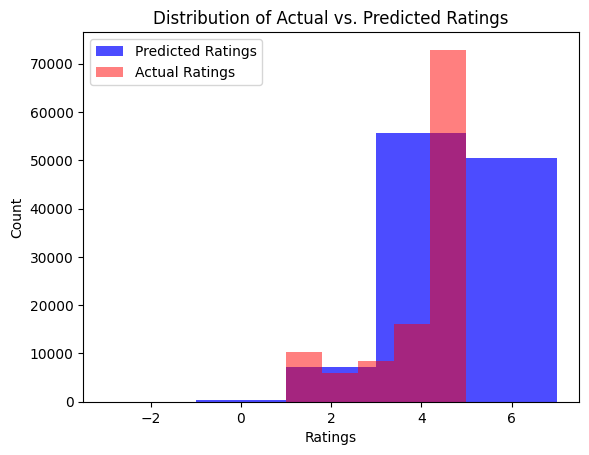

In [15]:
plt.hist(y_pred_rounded, bins=5, color='blue', alpha=0.7, label="Predicted Ratings")
plt.hist(y_test, bins=5, color='red', alpha=0.5, label="Actual Ratings")
plt.xlabel("Ratings")
plt.ylabel("Count")
plt.legend()
plt.title("Distribution of Actual vs. Predicted Ratings")
plt.show()


**Results**

In [16]:
# Select some random test reviews
sample_reviews = X_test[:5]  # Take first 5 reviews
sample_predictions = regressor.predict(sample_reviews)  # Predict ratings
sample_predictions = np.round(sample_predictions)  # Round to nearest whole number

# Print results
for i, review in enumerate(sample_reviews):
    print(f"Review: {X[i]}")
    print(f"Actual Rating: {y_test.iloc[i]}")
    print(f"Predicted Rating: {sample_predictions[i]}")
    print("-" * 80)


Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Actual Rating: 5
Predicted Rating: 5.0
--------------------------------------------------------------------------------
Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Actual Rating: 5
Predicted Rating: 5.0
--------------------------------------------------------------------------------
Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavor